# Modelling Language Change in Social Networks

## Introduction

This notebook would be divided into two parts. In the first part, a computational model which was proposed in the study of Fagyal, Swarup, Escobar, Gasser, & Lakkaraju (2010) would be replicated in pure Python. Their study mainly aims to investigate the dynamics of language change in different social networks using [agent-based model](https://en.wikipedia.org/wiki/Agent-based_model). In the second part, I would attempt to extend this original model, such as testing it with a real-world network.

## Theoretical Background

In sociolinguistics, there is a well-known S-shaped curve ([s-curve](https://www.uni-due.de/SHE/SHE_Transmission.htm)) to depict a process of language variants' diffusion, which can be segmented into three stages (see **Fig. 1**).

In the work of Fagyal et al. (2010), the s-curve would be seen as an evaluation to observe the change of language variants.

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/943204329094fac8592d5d7cc829bbf706865b0d/2-Figure1-1.png" width="40%" height="40%">

<center><b>Fig. 1.</b> Cumulative adoption of novel variants over time in three stages: emergence (<i>innovation</i>), selection and propagation (<i>diffusion</i>) and community-wide adoption (<i>fixation</i>). (This illustration is from the paper of Fagyal et al. (2010))</center>

## Computational Model Setup

The model contains three key components, 

1. **Network structure**
2. **Neighbour selection**
3. **Update rule**

### Network Structure
Firstly, the connection between individuals is seen as a bi-directional closed network (**Fig. 2**). Thus for each individual, he/she can be influenced by others and influence others. An example is the following.

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/943204329094fac8592d5d7cc829bbf706865b0d/6-Figure2-1.png" width="30%" height="30%">

<center><b>Fig. 2.</b> Types of influence in the network. Agent <b>A</b> might copy the variant of <b>B</b>, <b>D</b>, <b>E</b>, and <b>F</b>, but not <b>C</b>. Agent <b>C</b> is influenced by <b>A</b>, but <b>A</b> is not influenced by <b>C</b>. Arrows pointing to <b>A</b> are its in-degree (= 1), arrows pointing from <b>A</b> are its out-degree (= 4). The link between agents <b>F</b> and <b>E</b> is reciprocal; they can mutually copy each other’s variant. Agents <b>B</b> and D who have links pointing to them but not from them are loners who listen to no one else in this closed network. (This illustration is from the paper of Fagyal et al. (2010))</center>

In the model, an R-mat network (Chakrabarti, Zhan & Faloutsos, 2004) would be used to generate the above network. The parameters of R-mat are:

1. **900 nodes, 7561 edges;**
2. **a = 0.5, b = 0.1, c = 0.1, and d = 0.3.**

### Neighbour Selection
In the network, agents would choose a neighbour to interact according to the indegree of their neighbours every time. High indegree means a high probability to be chosen. The detailed rule is an *in-degree-biased voter model* which is the following,

$$P(i)=\frac{D_i}{\sum_{k=1}^{n}D_k}, \forall i, k, n \in N$$ 

where `P(i)` is the probability that the agent picks neighbor `i`, `Di` is the in-degree of neighbor `i`, and `n` is the set of all neighbors of the agent.

### Update Rule
In the interaction between two agents, each agent (node) only uses one language variant and there are several language variants in the entire network, the variant of the agent that is influenced by the other should be replaced by the other's variant. In this model,

3. **the number of variants = 8**.

## Code Structure

According to the above description, I would replicate it using pure python. Thus several libs would be imported,

In [1]:
import random
import snap    # snap===4.1.0-dev-Win-x64-py2.7
import matplotlib.pyplot as plt    # matplotlib==2.1.1
import numpy as np    # numpy==1.11.3
import pandas as pd    # pandas==0.23.4

from collections import (Counter, defaultdict)
from __future__ import division
from tqdm import trange    # tqdm==4.31.1

Specifically, the detailed installation of  `snap` lib can be found in [here](http://snap.stanford.edu/snappy/index.html). A python 2.7x is required. In addition, `trange` is equeal to `xrange` with a progress bar. Then I would create a object for replicating this computational model.

In [2]:
class VarDiffGraphModel(object):
    """
        Modelling variants diffusion in a social network
    """
    def __init__(self, num_var=8):
        """
        Initializing info

        :param num_var: the number of global language variants
        :return: None
        """
        # network info
        # the number of nodes and edges
        self.num_node = 0
        self.num_edge = 0
        # a connection dict for agents, e.g. conn_dict[2] = [2, 4, 5],
        # agent 1 connects with agent 2, 4 and 5.
        self.conn_dict = defaultdict(list)
        # a (in&out)-degree dict for agents, e.g. degree_list[2] = {3,1},
        # the in-degree of agent 2 is 1, its out-degree is 3.
        self.degree_list = list()
        # a dict of neighbour prob, e.g. neig_prob_dict[2] = [0.2, 0.3, 0.4]
        # the probs that agent 2 chooses its neighbours is 0.2, 0.3 and 0.4
        self.neig_prob_dict = dict()

        # variants info
        # the number of variants
        self.num_var = num_var
        self.all_var_list = range(self.num_var)
        # a var dict, e.g. var_list[2] = 1, agent 2 "speaks" variant 1
        self.var_list = list()
        self.last_var_list = list()
        # a dict of var of agents, e.g. var_change_list[1] = [1, 2, 2, 3]
        # in t=1, the vars of agent 0 to 3 are 1, 2, 2 and 3
        self.var_change_list = list()
        # a data frame for counting the number of variants
        # e.g. var_df[1] = [0, 1, 2, 1]
        # in t=1, the numbers of vars 0 to 3 are 0, 1, 2 and 1
        self.var_df = pd.DataFrame()

    def set_nstruct(self, netobj):
        """
        Setting the type of network, e.g. R-MAT network, the input should be a
        object of `snap.PNGraph` (directed graph).

        :param netobj: the object of `snap.PNGraph`
        :return: None
        """
        if isinstance(netobj, snap.PNGraph):
            self._G = netobj
        else:
            raise AttributeError("network object should be `snap.PNGraph`")

        self.num_node = self._G.GetNodes()
        self.num_edge = self._G.GetEdges()

        for EI in self._G.Edges():
            self.conn_dict[EI.GetSrcNId()].append(EI.GetDstNId())

        self.degree_list = [(EI.GetInDeg(), EI.GetOutDeg())
                            for EI in self._G.Nodes()]

        self.var_list = [random.randint(0, self.num_var - 1)
                         for _ in range(self.num_node)]
        self.last_var_list = self.var_list[:]
        self.var_df = pd.DataFrame(columns=self.all_var_list)
        var_freq_pt = Counter(self.var_list)
        # in case one of vars absence
        self.var_df = self.var_df.append(var_freq_pt, ignore_index=True)

    def set_sprob_by_ind(self):
        """
        Setting the connection probability by in-degree-biased, according to
        the following equation,
                                P(i) = Di / ∑Dk
        where P(i) is the probability that the agent picks neighbor i, Di is
        the in-degree of neighbor i, and N is the set of all neighbors of the
        agent.

        :return: None
        """
        for nid, EI in enumerate(self._G.Nodes()):
            neig_list = self.conn_dict.get(nid, list())
            if not neig_list:
                self.neig_prob_dict[nid] = list()
            else:
                neig_ind_list = [self.degree_list[neig][0]
                                 for neig in neig_list]
                neig_prob_list = np.array(neig_ind_list) / sum(neig_ind_list)
                self.neig_prob_dict[nid] = list(neig_prob_list)

    def set_sprob_by_rnd(self):
        """
        Setting the connection probability of neigbours by random assignment.

        :return: None
        """
        for nid, EI in enumerate(self._G.Nodes()):
            neig_list = self.conn_dict.get(nid, list())
            if not neig_list:
                self.neig_prob_dict[nid] = list()
            else:
                neig_prob_list = np.random.dirichlet(np.ones(len(neig_list)),
                                                     size=1)[0]
                self.neig_prob_dict[nid] = list(neig_prob_list)

    def set_sprob_by_ave(self):
        """
        Setting the selection probability of neighbours by average assignment.

        :return: None
        """
        for nid, EI in enumerate(self._G.Nodes()):
            neig_list = self.conn_dict.get(nid, list())
            if not neig_list:
                self.neig_prob_dict[nid] = list()
            else:
                ave_prob = 1 / len(neig_list)
                neig_prob_list = np.full_like(np.arange(len(neig_list),
                                                        dtype=float), ave_prob)
                self.neig_prob_dict[nid] = list(neig_prob_list)

    def diffusion(self, num_iter=1000):
        """
        Diffusion process, each agent updates its language variant by its
        neighbour's variant (replacement).

        :param num_iter: the number of interaction iteration
        :return: None
        """
        for i in trange(num_iter, ascii=True, desc='Interaction %'):
            self.variants_update()
            
            self.var_change_list.append(self.var_list[:])

            var_freq_pt = Counter(self.var_list)
            self.var_df = self.var_df.append(var_freq_pt, ignore_index=True)

        # converting the value of `nan` to zero
        self.var_df = self.var_df.fillna(0)

    def neighbour_selection(self, node_id):
        """
        Choosing a neighbour according to their its probability.

        :param node_id: agent's id
        :return: the id of agent's neighbour
        """
        neig_list = self.conn_dict[node_id]
        if not neig_list:
            return -1
        neig_prob_list = self.neig_prob_dict[node_id]
        return self.prob_choice(neig_list, neig_prob_list)

    def variants_update(self):
        """
        Replacing the agent's language variant as the variant of its selected
        neighbour.

        :return: None
        """
        for node_id in xrange(self.num_node):
            neig_id = self.neighbour_selection(node_id)
            # make sure at least one neighbour, then update the variants
            if neig_id != -1:
                self.var_list[node_id] = self.last_var_list[neig_id]
        self.last_var_list = self.var_list[:]

    def prob_choice(self, item_list, prob_list):
        """
        Choosing a item from a list via items' probabilities

        :param item_list: a list with items that need to choose
        :param prob_list: a list of each item's probability
        :return: selected item
        """
        # this method is faster than `np.random.choice`, because
        # https://eli.thegreenplace.net/2018/slow-and-fast-methods-for-generating-random-integers-in-python/
        if item_list and prob_list:
            x = random.uniform(0, 1)
            cumul_prob = 0.0
            for item, item_prob in zip(item_list, prob_list):
                cumul_prob += item_prob
                if x < cumul_prob:
                    break
            return item
        else:
            raise ValueError('item list and prob list should be not empty.')

    def indegree_figure(self):
        """
        Plotting the in-degree distribution of graph

        :return: None
        """
        # TODO: using `snap` method to count
        ind = Counter([d[0] for d in self.degree_list])

        plt.style.use('seaborn-paper')
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.figure()

        plt.title('In-degree Distribution')
        plt.xlabel('In-degree')
        plt.ylabel('Number of nodes')
        plt.scatter(ind.keys(), ind.values(), alpha=0.8)
        plt.show()

    def diffusion_figure(self):
        """
        Plotting the change of language variants of graph with time

        :param show: whether show the figure, default is `True`
        :return: None
        """
        plt.style.use('seaborn-paper')
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.figure(1)
        plt.subplots_adjust(hspace=0.5)

        # figure 1, global
        plt.subplot(211)
        plt.title('(a) Language change (global)')
        plt.xlabel('Time')
        plt.ylabel('Number of nodes')
        for var in self.all_var_list:
            plt.plot(range(len(self.var_df[var])), self.var_df[var],
                     label='Variant {}'.format(var), linewidth=0.5)

        # figure 2, local
        plt.subplot(212)
        plt.title('(b) Language change (local)')
        plt.xlabel('Time')
        plt.ylabel('Number of nodes')
        for var in self.all_var_list:
            plt.plot(range(len(self.var_df[var])), self.var_df[var],
                     label='Variant {}'.format(var), linewidth=0.5)
        plt.show()

### Main methods

`set_nstruct(self, netobj)`: Select the type of network;

`neighbour_selection(self, node_id)`: Select a neighbour;

`variants_update(self)`: Update the own variant in a interaction.


### Process (pseudo-code)

``` python
__init__()

for node_id in agents:
    neig_id = neighbour_selection(node_id)
    var[node_id] = var[neig_id]
```

## Execution

### In-degree distribution

According to the distribution of in-degree (**Fig. 3 (a)**), the maximum in-degree in the network is 53. Additionally, an agent with relatively high in-degree is called *hub*, an agent with zero out-degree is called *loner* (see **Fig. 3 (b)**).

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/943204329094fac8592d5d7cc829bbf706865b0d/9-Figure4-1.png" width="30%" height="30%">

<center><b>Fig. 3.</b> (a) In-degree distribution for nodes in the scale-free network used in the simulation. Extremely highly influential <i>hubs</i> are in the bottom-right corner, agents with average influence (middle) and <i>loners</i> with very little influence over others are in upper-left corner; (b) <i>hubs</i> in the center and <i>loners</i> on the peripheries of the network (This illustration is from the paper of Fagyal et al. (2010))</center>

When a network was created, its in-degree distribution can be seen in `indegree_figure()` method.

<IPython.core.display.Javascript object>


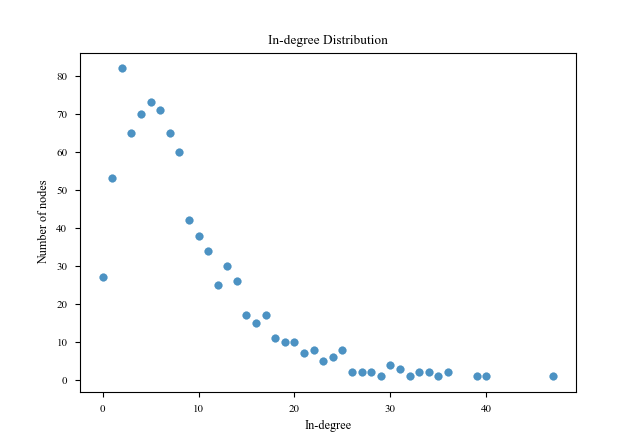

In [3]:
# for interactive figure
%matplotlib notebook

# instantiation
var_graph = VarDiffGraphModel()
# R-mat graph generator
var_graph.set_nstruct(snap.GenRMat(900, 7561, 0.5, 0.1, 0.1, snap.TRnd()))
# in-degree-biased selection
var_graph.set_sprob_by_ind()
# plot the in-degree distribution
var_graph.indegree_figure()

It seems the in-degree distribution pattern of result is similiar to **Fig 3. (a)**.

### Result

According to the result of Fagyal et al. (2010), five variants showed an s-curve one by one in 40,000 iterations (see **Fig. 4**). It is because there are several loners in the network. They would preserve the weak variants which would come alive again over time.

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/943204329094fac8592d5d7cc829bbf706865b0d/10-Figure5-1.png" width="50%" height="50%">

<center><b>Fig. 4.</b> (a) Number of agents adopting each of the competing variants in the network over time; (b) periods of partial diffusion preceding establishment as norm for the last two variants; (c) middle portion of an S-like diffusion path of one variant on an extended time scale. (This illustration is from the paper of Fagyal et al. (2010))</center>

The simulation is the following,

Interaction %: 100%|##########| 40000/40000 [10:28<00:00, 63.66it/s] 


<IPython.core.display.Javascript object>


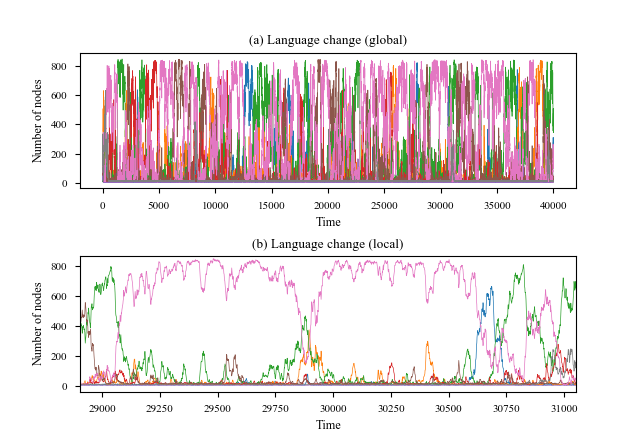

In [4]:
# 40,000 iterations
var_graph.diffusion(40000)
# plot the language change dynamics
var_graph.diffusion_figure()

According to (a), it showed a similar pattern with **Fig. 4 (a)**, there is a strong variant (e.g. peak, green) in each period. (b) showed the s-curve (You can run this code in your local, then you can zoom in to see the detail).

## Manipulations

After the above simulation, the original paper had three manipulations,

1. **Changing the number of nodes**;
2. **Using other network structure**;
3. **Changing update rule**.

### Lack of loners

For removing the loners, the edges would be added to 27,000. The result showed in **Fig. 5**. Because without the loners, the weak variants cannot be preserved, so it is easy to reach convergence.

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/943204329094fac8592d5d7cc829bbf706865b0d/11-Figure6-1.png" width="30%" height="30%">

<center><b>Fig. 5.</b> Rapid convergence and fixation of one variant as norm when density of communication is increased to the point where no <i>loners</i> remain in the network. (This illustration is from the paper of Fagyal et al. (2010))</center>

The simulation is the following,

<IPython.core.display.Javascript object>


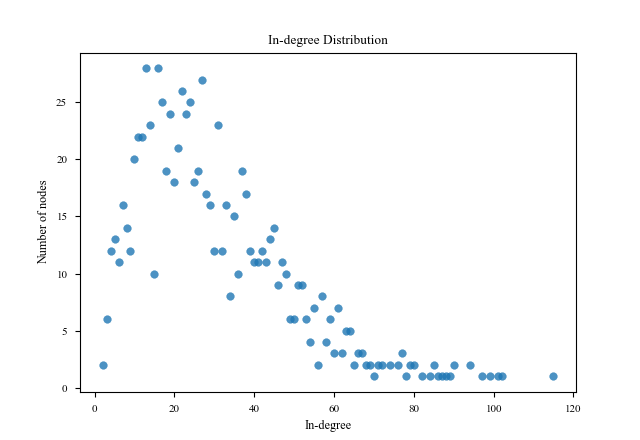

In [5]:
# only change the edges, in fact, this value should be a little less than 27,000
var_graph = VarDiffGraphModel()
var_graph.set_nstruct(snap.GenRMat(900, 27000, 0.5, 0.1, 0.1, snap.TRnd()))
var_graph.set_sprob_by_ind()
var_graph.indegree_figure()

Interaction %: 100%|##########| 40000/40000 [14:06<00:00, 47.23it/s]


<IPython.core.display.Javascript object>


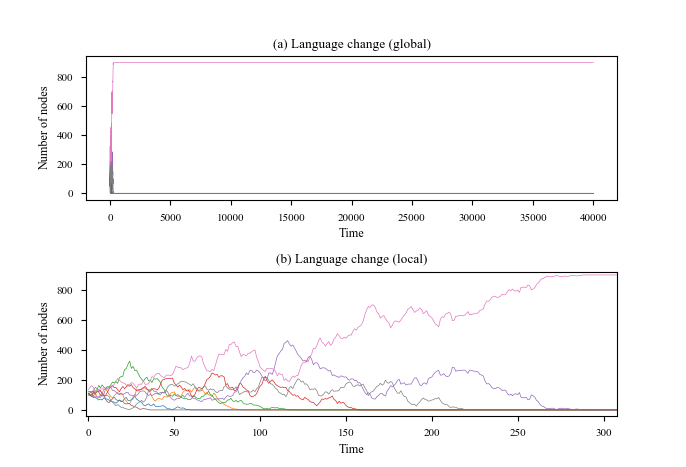

In [6]:
var_graph.diffusion(40000)
var_graph.diffusion_figure()

According to in-degree distribution (out-degree dist should be showed), loners have removed. (a) showed a global change which is similar to **Fig. 5**. In (b), it is clear to know that the variants remained stable in about 270.

### Lack of leaders

Next, in order to remove hubs and retain about 5% loners, 3,000 edges would be instead of 7,561 edges and a random network would be used.

The result (see Fig. 6) showed that the norms failed to appear because there was not an absolute strong variant in each time.

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/943204329094fac8592d5d7cc829bbf706865b0d/12-Figure7-1.png" width="30%" height="30%">

<center><b>Fig. 6.</b> Norms fail to appear when the structure of the network is changed as to remove highly-influential local communities (no hubs). (This illustration is from the paper of Fagyal et al. (2010))</center>

The simulation is the following,

<IPython.core.display.Javascript object>


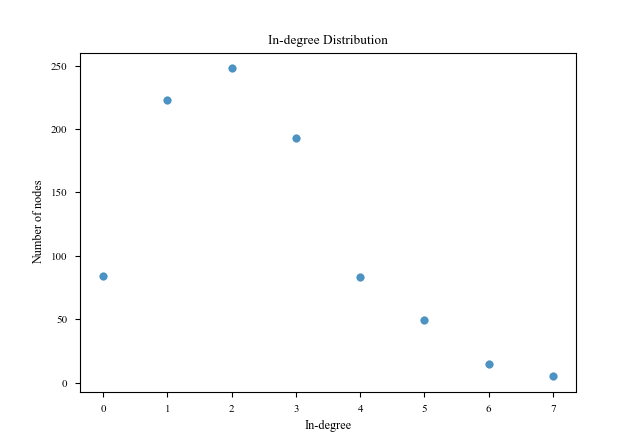

In [7]:
# change the number of edge (2,000) and network structure
var_graph = VarDiffGraphModel()
var_graph.set_nstruct(snap.GenRndGnm(snap.PNGraph, 900, 2000))
var_graph.set_sprob_by_ind()
var_graph.indegree_figure()

Interaction %: 100%|##########| 40000/40000 [10:07<00:00, 65.87it/s] 


<IPython.core.display.Javascript object>


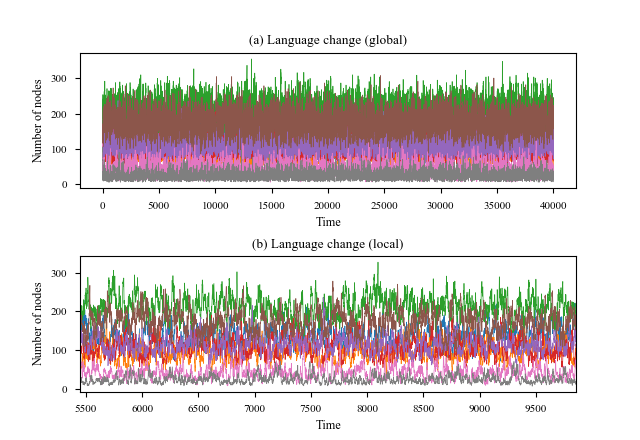

In [8]:
var_graph.diffusion(40000)
var_graph.diffusion_figure()

<IPython.core.display.Javascript object>


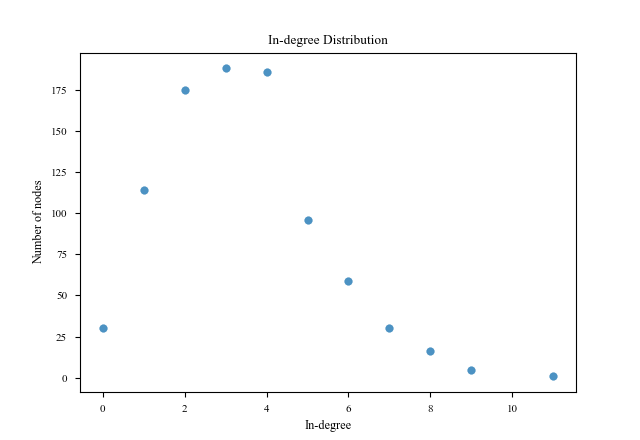

In [11]:
# change the number of edges (3,000) and network structure
var_graph = VarDiffGraphModel()
var_graph.set_nstruct(snap.GenRndGnm(snap.PNGraph, 900, 3000))
var_graph.set_sprob_by_ind()
var_graph.indegree_figure()

Interaction %: 100%|##########| 40000/40000 [10:16<00:00, 64.84it/s] 


<IPython.core.display.Javascript object>


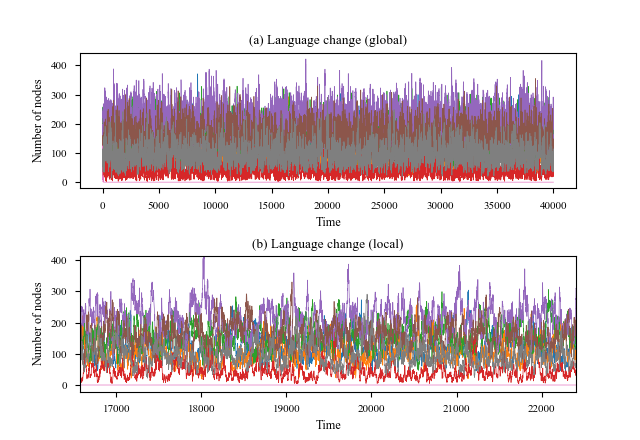

In [12]:
var_graph.diffusion(40000)
var_graph.diffusion_figure()

Because of the slight differences in algorithm implementation, the two simulations (2,000 and 3,000 edges) would be run respectively. 2,000 edges simulation is closer to 5% loners. The results showed a similar pattern.

### Manipulating individual prestige

Finally, in-degree-biased selection would be replaced by two new update rules. Firstly, the neighbours would be selected equally (in the same probability). Furthermore, neighbours would be selected randomly. The results (see **Fig. 7**) showed that norms failed to appear because absolute strong variants cannot preserve.

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/943204329094fac8592d5d7cc829bbf706865b0d/13-Figure8-1.png" width="60%" height="60%">

<center><b>Fig. 7.</b> Variants dominate in the population at different times, but there is no fixation of norm when agents chose a neighbor to copy by (a) treating all agents equally, or (b) biasing their choice on the basis of a fixed random number assigned to each agent. (This illustration is from the paper of Fagyal et al. (2010))</center>

The simulation is the following,

<IPython.core.display.Javascript object>


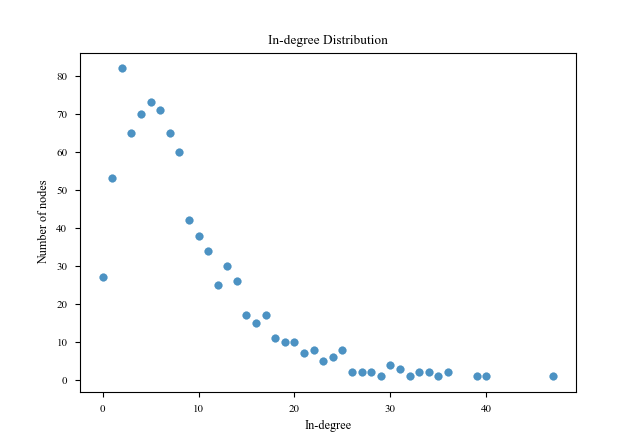

In [13]:
# average assignment
var_graph = VarDiffGraphModel()
var_graph.set_nstruct(snap.GenRMat(900, 7561, 0.5, 0.1, 0.1, snap.TRnd()))
var_graph.set_sprob_by_ave()
var_graph.indegree_figure()

Interaction %: 100%|##########| 40000/40000 [11:28<00:00, 58.13it/s]


<IPython.core.display.Javascript object>


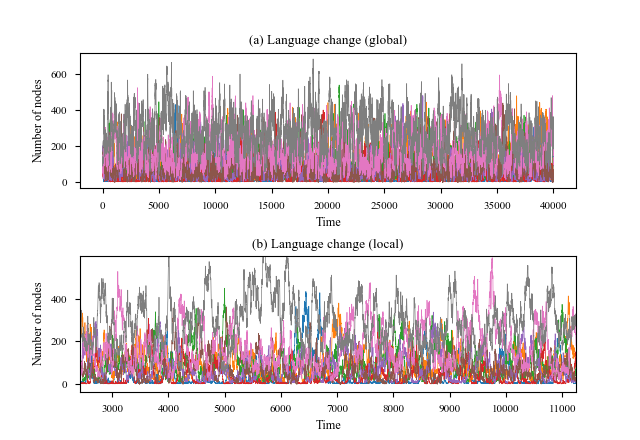

In [14]:
var_graph.diffusion(40000)
var_graph.diffusion_figure()

The result is really chaotic which is similar to (a).

<IPython.core.display.Javascript object>


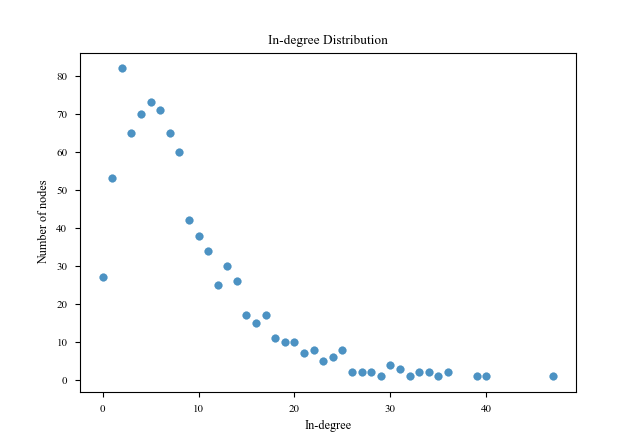

In [15]:
# random assignment
var_graph = VarDiffGraphModel()
var_graph.set_nstruct(snap.GenRMat(900, 7561, 0.5, 0.1, 0.1, snap.TRnd()))
var_graph.set_sprob_by_rnd()
var_graph.indegree_figure()

Interaction %: 100%|##########| 40000/40000 [11:29<00:00, 58.00it/s]


<IPython.core.display.Javascript object>


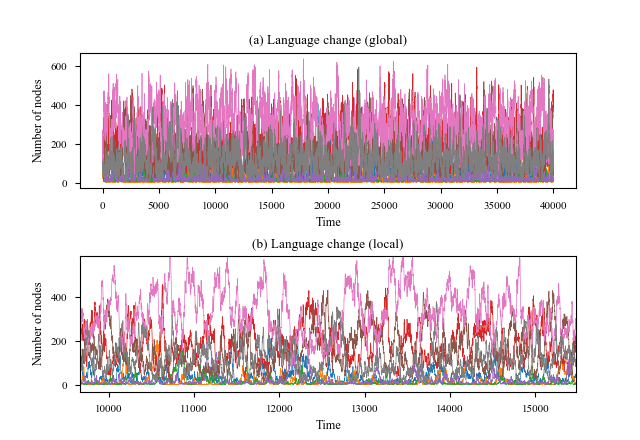

In [16]:
var_graph.diffusion(40000)
var_graph.diffusion_figure()

The result is also chaotic which is similar to (b). But there are several "relatively strong" variants (in peak and red).

## Code Optimization

1. **Fix the `TODO` issue**
2. **Memory leak for `df`**
3. **`__del__` for the class `VarDiffGraphModel`**
4. **Speed up**
5. ** * try to use some ABM framework in python (e.g. `[Mesa](https://github.com/projectmesa/mesa)`)**

## Extension

In this part, I would like to add some new factors into the model I have replicated. In fact, previous manipulations have mainly adjusted the parameters. Thus in here, I will focus on real-world data, visualization and dynamics.

### Real-World Dataset

Firstly, I will use a real social network which is called [Epinions](http://snap.stanford.edu/data/soc-Epinions1.html) to test the model. I would like to know whether norms appear. Here is some intro for Epinions network.

> This is a who-trust-whom online social network of a a general consumer review site [Epinions.com](http://www.epinions.com/). Members of the site can decide whether to ''trust'' each other. All the trust relationships interact and form the Web of Trust which is then combined with review ratings to determine which reviews are shown to the user.

The simulation is the following,

<IPython.core.display.Javascript object>


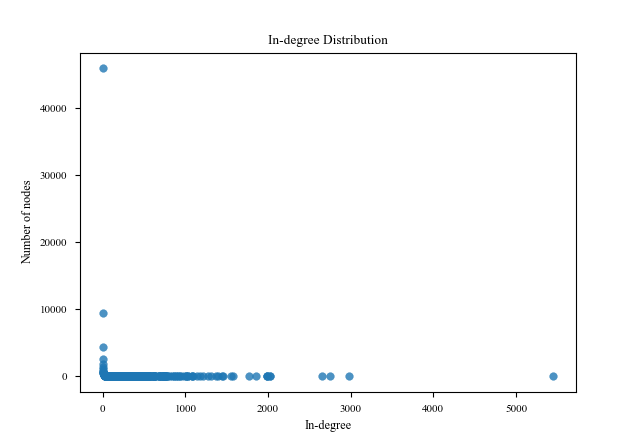

In [17]:
# switch to Epinions network, which is equivalent to
# `snap.GenRMat(75888, 508837, 0.550, 0.228, 0.212)`
var_graph = VarDiffGraphModel()
var_graph.set_nstruct(snap.GenRMatEpinions())
var_graph.set_sprob_by_ind()
var_graph.indegree_figure()

Interaction %: 100%|##########| 7500/7500 [32:54<00:00,  3.82it/s] 


<IPython.core.display.Javascript object>


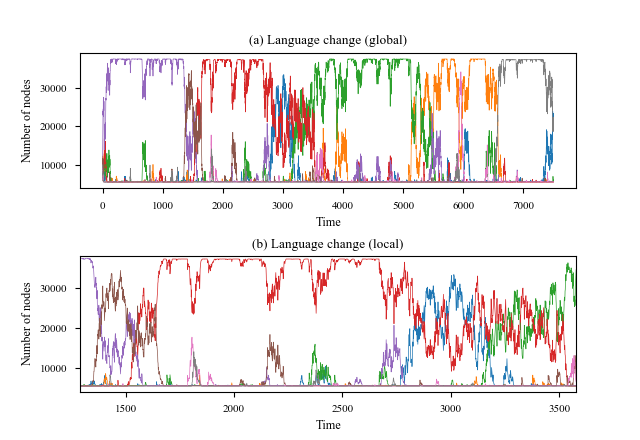

In [18]:
var_graph.diffusion(7500)
var_graph.diffusion_figure()

Surprisingly, the Epinions also fit the ABM and it seems that better fit than **Fig. 4** experiment I replicated. (only 7,500 iterations because my laptop is too old to run 40,000 iterations...). I am analysed the network structure now.

### Mathematical Analysis
Swarup, Apolloni, & Fagyal (2011) completed their work based on this original paper. Compared to the paper they published in `Lingua`, the study of 2011 which was published in `AAMAS` is more mathematical. They added more mathematical analysis. Thus I will read this paper for learning to analyse the network structure and probability in math.

### Spatial Map
To create a spatial map to see the language change in space and distance (De Bie, & De Boer, 2007).

### Visualization
To observe the change in social networks.

### * Dynamic Network
To create a dynamic network with dynamic connection.

### * Dynamic Population Growth
Dynamic population growth with life span.

### * Multi-Community
To observe inter-community and intra-community change in a whole social network.

## Reference

> * Chakrabarti, D., Zhan, Y., & Faloutsos, C. (2004, April). [R-MAT: A recursive model for graph mining](https://epubs.siam.org/doi/abs/10.1137/1.9781611972740.43). In *Proceedings of the 2004 SIAM International Conference on Data Mining* (pp. 442-446). Society for Industrial and Applied Mathematics.
> * De Bie, P., & De Boer, B. (2007). [An agent-based model of linguistic diversity](https://www.scss.tcd.ie/conferences/esslli2007/content/CD_Contents/content/id42/id42.pdf#page=7). *Language, Games, and Evolution, 1*.
> * Fagyal, Z., Swarup, S., Escobar, A. M., Gasser, L., & Lakkaraju, K. (2010). [Centers and peripheries: Network roles in language change](https://www.sciencedirect.com/science/article/pii/S0024384110000203). *Lingua, 120*(8), 2061-2079.
> * Leskovec, J., & Sosič, R. (2016). [Snap: A general-purpose network analysis and graph-mining library](https://dl.acm.org/citation.cfm?id=2898361). *ACM Transactions on Intelligent Systems and Technology (TIST), 8*(1), 1.
> * Richardson, M., Agrawal, R., & Domingos, P. (2003, October). [Trust management for the semantic web](https://link.springer.com/chapter/10.1007/978-3-540-39718-2_23). In *International semantic Web conference* (pp. 351-368). Springer, Berlin, Heidelberg.
> * Swarup, S., Apolloni, A., & Fagyal, Z. (2011, May). [A model of norm emergence and innovation in language change](https://dl.acm.org/citation.cfm?id=2031716). In *The 10th International Conference on Autonomous Agents and Multiagent Systems-Volume 2* (pp. 693-700). International Foundation for Autonomous Agents and Multiagent Systems.
> * Van Bavel, J., & Grow, A. (2017). Introduction: Agent-based modelling as a tool to advance evolutionary population theory. In *Agent-based modelling in population studies* (pp. 3-27). Springer, Cham.